In [45]:
# naively implementing CNOT on dual-rail
from qutip import tensor, basis, Qobj
import numpy as np
from quantum_logical.basis import DualRail
from quantum_logical.unitary_util import ImplicitUnitaryGate
from qiskit.circuit.library import HGate, CXGate
from qiskit import QuantumCircuit
from weylchamber import c1c2c3
from qiskit.quantum_info import Operator

Load the dualrail encoding and convert HGate and CNOT gate into logical gates


In [46]:
encoding = DualRail()
op = encoding.logical_basis.transform_operator.full()

In [47]:
# U = |01><0| + |10><1|
print(op)

[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]


In [48]:
# for 2 qubits
# U = |0101><00| + |0110><01| + |1001><10| + |1010><11|
print(np.kron(op, op))

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [49]:
# A' = U @ A @ U^dag
new_op = op @ HGate().to_matrix() @ op.conj().T
logical_h = ImplicitUnitaryGate(new_op)

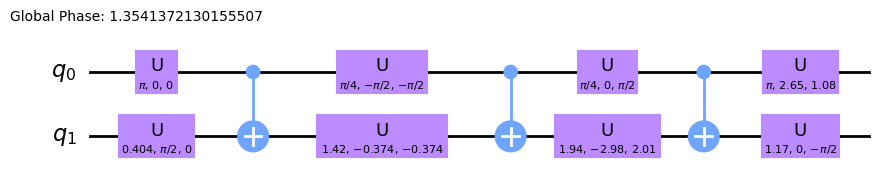

In [50]:
qc = QuantumCircuit(2)
qc.append(ImplicitUnitaryGate(logical_h), [0, 1])
qc.decompose().draw("mpl")

In [51]:
# note logical H is a physical ECP gate
c1c2c3(ImplicitUnitaryGate(new_op).to_matrix())

(0.5, 0.25, 0.25)

In [52]:
# A' = U @ A @ U^dag
new_op = np.kron(op, op) @ CXGate().to_matrix() @ np.kron(op, op).conj().T
logical_cnot = ImplicitUnitaryGate(new_op)
print(np.real(logical_cnot.to_matrix()))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


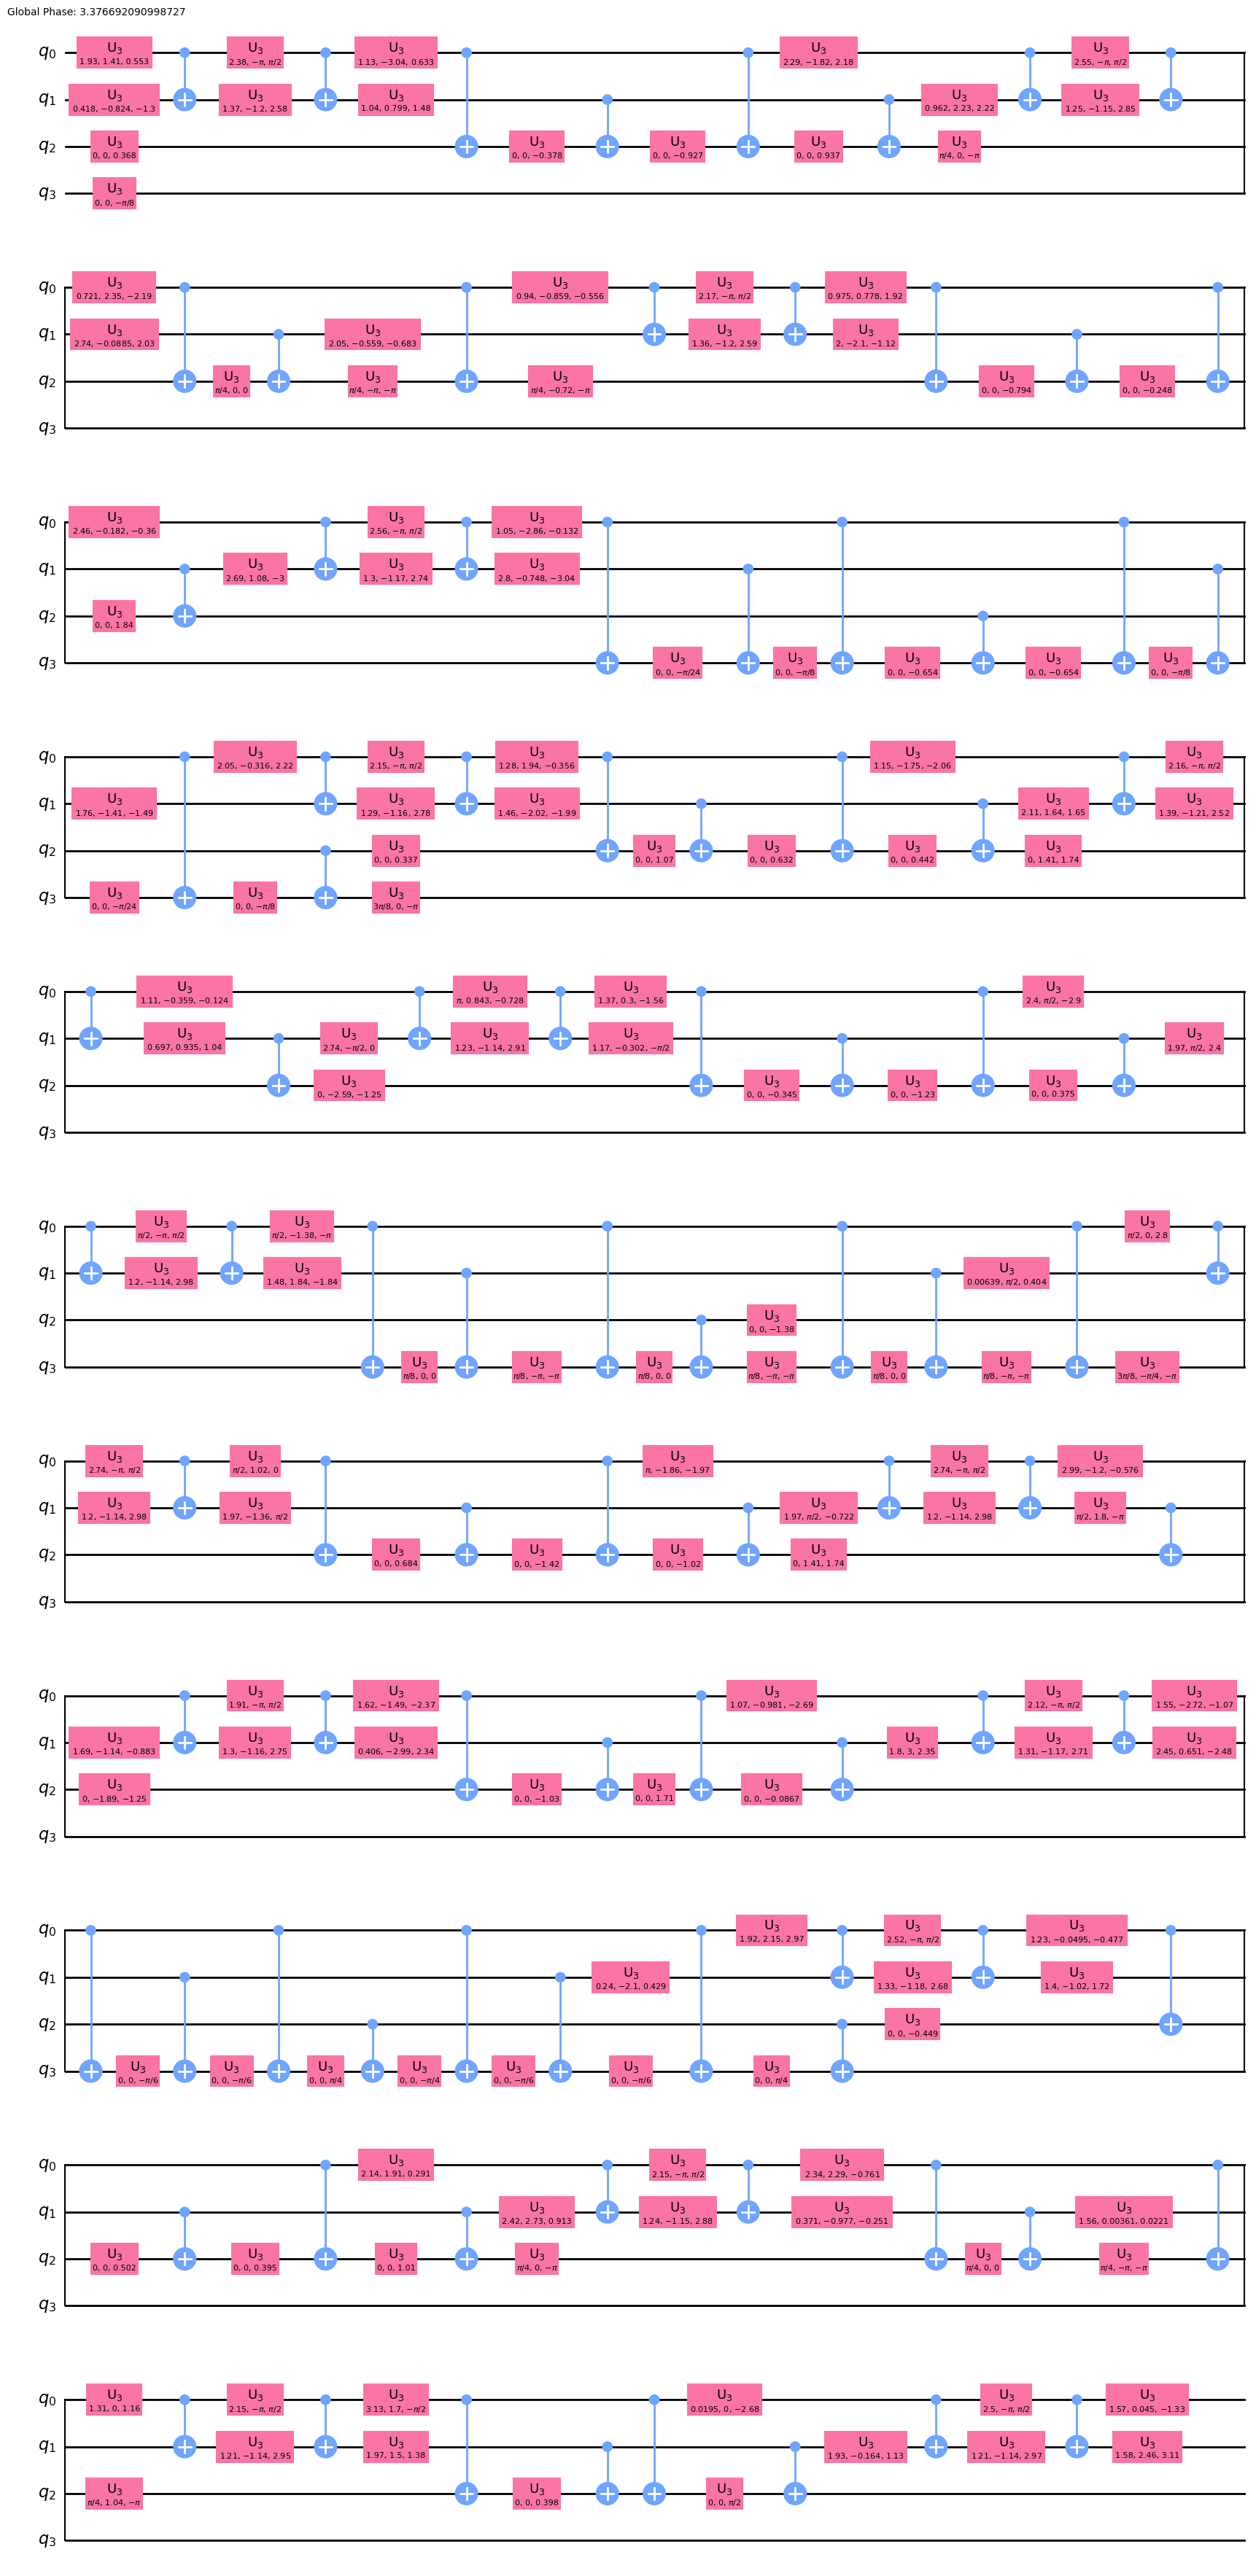

In [53]:
# look at how expensive the overhead is !!!
qc = QuantumCircuit(4)
qc.append(logical_cnot, [0, 1, 2, 3])
qc.decompose().draw("mpl")
optimized = transpile(qc, basis_gates=["cx", "u3"], optimization_level=3)
optimized.draw("mpl")

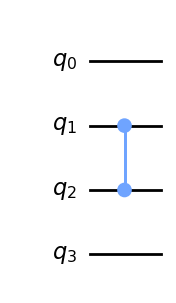

In [68]:
# clearly this is a bad idea
# we should instead do a cheaper operator on the basis, then determine what logical operator it is
# trying to build a CNOT in dual-rail is so expensive since not naturally suited for it
# so explore building gate other direction, start from the encoding and build a gate

qc = QuantumCircuit(4)
qc.cz(1, 2)
display(qc.draw("mpl"))

# what does this gate do on the encoding?
cz_op = Operator(qc).data

In [69]:
# A = U^dag @ A' @ U
new_op = np.kron(op, op).conj().T @ cz_op @ np.kron(op, op)
logical_cnot = ImplicitUnitaryGate(new_op)
print(np.real(logical_cnot.to_matrix()))

# looks like we built a much cheaper CNOT :)
print(c1c2c3(logical_cnot.to_matrix()))

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
(0.5, 0.0, 0.0)
